# Running `get_coalescent`

Once we have [created a population by specifying its transmission history](create-population.ipynb), it is very simple to perform a [Markov chain simulation of coalescence times](coalescence-time-basic.ipynb) by invoking the population method `get_coalescent`.

In [ ]:
!pip install coalestr
from coalestr import cs

In [2]:
# Specify the transmission history of a population
# Each inner list gives [duration, N, Q, X, M] for a period of history
my_history = [[1000, 30, 10, 0, 0], [1000, 10, 5, 0.5, 0]]

# Create the population
my_population = cs.Population(my_history)

# Obtain coalescence times
my_population.get_coalescent()

Observation time.    Events captured.   Mean coalescence time
                      beho      wiho        beho     wiho
        0             100.0     100.0        25.1     18.9


**Mean coalescence time**

The 'beho' or **between-host** column on the right tells us that two alleles sampled from different hosts have a mean coalescence time of 25.1 generations. 

The 'wiho' or **within-host** column on the right tells us that two alleles sampled from the same host have a mean coalescence time of 18.9 generations.  

**Events captured**

The 'events captured' columns tell us that 100% of coalescent events are captured for both the between-host and the within-host simulation. This is an important QC check because we want to be sure that our simulation runs for long enough to capture the vast majority of coalescent events.

Let us see what happens if we drastically reduce the duration of our population history.

In [6]:
my_history = [[30, 30, 10, 0, 0], [10, 10, 5, 0.5, 0]]

my_population = cs.Population(my_history)

my_population.get_coalescent()

Observation time.    Events captured.   Mean coalescence time
                      beho      wiho        beho     wiho
        0              68.6      77.2        10.7      8.4


Here we appear to have shorter coalescence times but the results are unreliable because we are capturing only 68.6% of coalescent events for the between-host simulation and 77.2% of coalescent events for the within-host simulation.

# Observation times

In the above examples we made a single observation of the population at observation time = 0.  This means that we sampled two alleles at time = 0 and followed their lineages back in time until they coalesced.  Since we are proceeding back in time, observation time 0 means the present, or the most recent generation in the population history.

If we want to see how the genetic diversity of the population changes over time, then we need to make observations at multiple time points.  For example, we might make observations every 500 generations. We can do this by providing `get_coalescent` with a list of observation times, always remembering that we are counting in backwards time, so observation time = 500 means 500 generations before the present.

In [31]:
my_history = [[1000, 30, 10, 0, 0], [1000, 10, 5, 0.5, 0]]

my_observations = [0, 500, 1000, 1500]

my_population = cs.Population(my_history)

my_population.get_coalescent(observe = my_observations)

Observation time.    Events captured.   Mean coalescence time
                      beho      wiho        beho     wiho
        0             100.0     100.0        25.1     18.9
      500             100.0     100.0        25.1     18.9
     1000             100.0     100.0        39.0     10.0
     1500             100.0     100.0        39.0     10.0


In [32]:
# We can also give the observation times as a range like this

my_observations = range(0, 2000, 500)

my_population.get_coalescent(observe = my_observations)

Observation time.    Events captured.   Mean coalescence time
                      beho      wiho        beho     wiho
        0             100.0     100.0        25.1     18.9
      500             100.0     100.0        25.1     18.9
     1000             100.0     100.0        39.0     10.0
     1500             100.0     100.0        39.0     10.0


In [33]:
# We can retrieve a list of observation times as a population attribute

my_population.observation_times

[0, 500, 1000, 1500]

# Data produced by `get_coalescent`

`get_coalescent` generates various data arrays that can be retrieved as population attributes, including:

* `report`
* `beho_lineage`
* `wiho_lineage`
* `coalescent`

The population attribute `report` gives a summary of coalescence events for different observation times.

* axis 0 : observation_times[i]
* axis 1 : summary of coalescence events
  * 0: observation time
  * 1: beho: percentage of coalescent events captured
  * 2: wiho: percentage of coalescent events captured
  * 3: beho: expectation of coalescence time
  * 4: wiho: expectation of coalescence_time
  * 5: eco setpoint: proportion of coalescences to capture
  * 6: break time

In [34]:
for i in range(len(my_population.observation_times)):
    
    print("At observation time {0:1.0f} the mean time to coalescence was\
    \n   {1:1.1f} for a between-host sample\
    \n   {2:1.1f} for a within-host sample".format(
        my_population.report[i, 0],
        my_population.report[i, 3],
        my_population.report[i, 4]))
            

At observation time 0 the mean time to coalescence was    
   25.1 for a between-host sample    
   18.9 for a within-host sample
At observation time 500 the mean time to coalescence was    
   25.1 for a between-host sample    
   18.9 for a within-host sample
At observation time 1000 the mean time to coalescence was    
   39.0 for a between-host sample    
   10.0 for a within-host sample
At observation time 1500 the mean time to coalescence was    
   39.0 for a between-host sample    
   10.0 for a within-host sample


The population attribute `beho_lineage` describes variation over time in the **state of two lineages sampled from different hosts** at observation time 0.  This will allow us to estimate between-host levels of genetic diversity.

The population attribute `wiho_lineage` describes variation over time in the **state of two lineages sampled from the same host** at observation time 0.  This will allow us to estimate within-host levels of genetic diversity.

* axis 0: backwards time
* axis 1: 
  * 0: probability that lineages are separated
  * 1: probability that lineages are cotransmitted
  * 2: probability that lineages are coalesced
  * 3: blank
  * 4: blank
  * 5: probability of coalescence occuring at this timepoint
  * 6: summation series for expectation of coalescence time
  
Let us see how `beho_lineage` and `wiho_lineage` can be used to plot the state of two lineages going back in time for `my_population` created above.

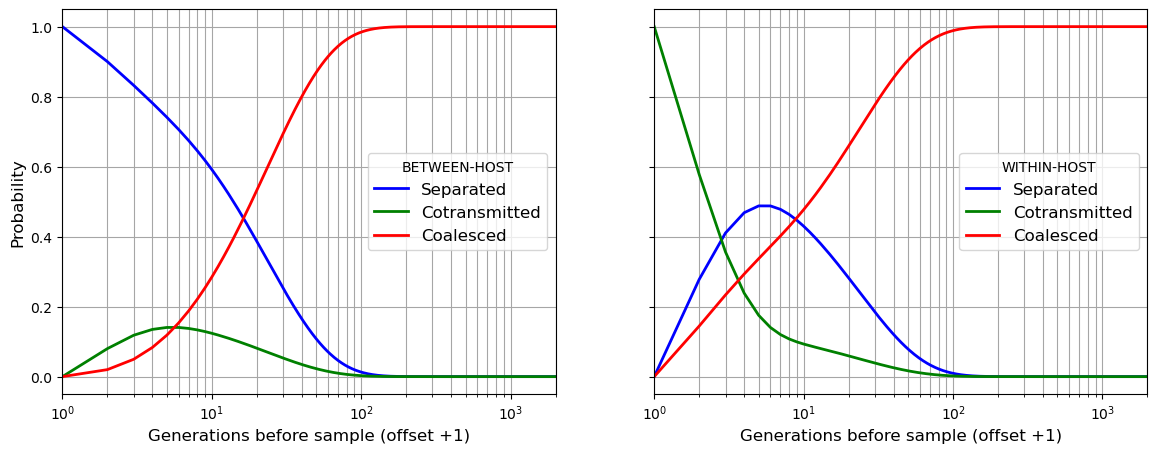

In [35]:
import matplotlib.pyplot as plt

b_separated = my_population.beho_lineage[:, 0]
b_cotransmitted = my_population.beho_lineage[:, 1]
b_coalesced = my_population.beho_lineage[:, 2]

w_separated = my_population.wiho_lineage[:, 0]
w_cotransmitted = my_population.wiho_lineage[:, 1]
w_coalesced = my_population.wiho_lineage[:, 2]

timescale = range(1, my_population.t_his + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), sharex = True, sharey = True)

ax1.plot(timescale, b_separated, marker='', color='blue', linewidth = 2, label="Separated")
ax1.plot(timescale, b_cotransmitted, marker='', color='green', linewidth = 2, label="Cotransmitted")
ax1.plot(timescale, b_coalesced, marker='', color='red', linewidth = 2, label="Coalesced")

ax2.plot(timescale, w_separated, marker='', color='blue', linewidth = 2, label="Separated")
ax2.plot(timescale, w_cotransmitted, marker='', color='green', linewidth = 2, label="Cotransmitted")
ax2.plot(timescale, w_coalesced, marker='', color='red', linewidth = 2, label="Coalesced")

ax1.legend(title="BETWEEN-HOST",frameon=True, fontsize=12)
ax2.legend(title="WITHIN-HOST",frameon=True, fontsize=12)
ax1.set_xlabel("Generations before sample (offset +1)", fontsize=12)
ax2.set_xlabel("Generations before sample (offset +1)", fontsize=12)
ax1.set_ylabel("Probability", fontsize=12)
ax1.set_xscale('log',base=10)
ax1.set_xlim(1,my_population.t_his)
ax1.grid(visible=True, which='both', color='0.65', linestyle='-')
ax2.grid(visible=True, which='both', color='0.65', linestyle='-')

plt.show()

The population attribute `coalescent` describes the probability distribution of time to coalescence at different observation times.  Recall that the population attribute `observation_times` is a list of observation times.

* axis 0 : observation_times[i]
* axis 1 : backwards time
* axis 2 : probability distribution of time to coalescence
  * 0: beho: probability of coalescence occurring at this timepoint
  * 1: wiho: probability of coalescence occurring at this timepoint
  
Let us see how this can be used to plot the probability distribution of coalescence times for observation time = 0.

In [37]:
my_population.observation_times

[0, 500, 1000, 1500]

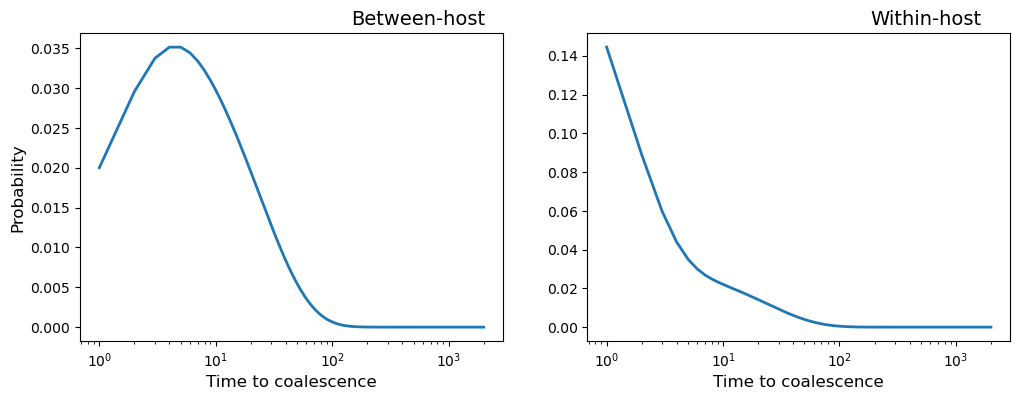

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), sharex = True)

timescale = range(1, my_population.t_his)
beho_coalescent = my_population.coalescent[0, 1:, 0]
wiho_coalescent = my_population.coalescent[0, 1:, 1]

ax1.plot(timescale, beho_coalescent, marker='', linewidth=2)
    
ax2.plot(timescale, wiho_coalescent, marker='', linewidth=2)
    
ax1.set_title("Between-host", position=(0.8, 0.3), fontsize=14)
ax2.set_title("Within-host", position=(0.8, 0.3), fontsize=14)
ax1.set_xlabel("Time to coalescence", fontsize=12)
ax2.set_xlabel("Time to coalescence", fontsize=12)
ax1.set_ylabel("Probability", fontsize=12)
ax1.set_xscale('log',base=10)

plt.show()